In [9]:
### IMPORTS:

In [59]:
!pip install seaborn==0.11.0

     |████████████████████████████████| 283 kB 3.8 MB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0


In [1]:
import math
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import seaborn as sns
sns.set_theme(style="whitegrid")
from functools import reduce

In [5]:
### DATASET UTILS:

In [2]:
# See: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

from torch.utils.data import Dataset
import pandas as pd
import pickle

STANCE_MAP = {
    'agree':0,
    'disagree':1,
    'discuss':2,
    'unrelated':3,
}
STANCE_MAP_INV = dict((v,k) for k, v in STANCE_MAP.items())

# This map makes a 2-class classification task, where
# labels are just 'related=1', or 'unrelated=0'.
RELATED_STANCE_MAP = {
    'unrelated':0,
    'agree':1,
    'disagree':1,
    'discuss':1,
}
RELATED_STANCE_MAP_INV = {0: 'unrelated', 1: 'related'}

class FakeNewsEncodedDataset(Dataset):
    def __init__(self, stances_file, bodies_file, no_unrelated=False, related_task=False):
        self.stances = []
        self.sim_bodies = {}
        self.nli_bodies = {}
        self.related_task = related_task
        
        with open(stances_file, "rb") as sf:
            completed_read = False
            while not completed_read:
                try:
                    stance = pickle.load(sf)
                    if no_unrelated and stance[3] == 'unrelated':
                        continue
                    self.stances.append(stance) # TODO: memory inefficient?
                except EOFError:
                    completed_read = True
        
        with open(bodies_file, "rb") as bf:
            completed_read = False
            while not completed_read:
                try:
                    body_id, sim_embeddings, nli_embeddings = pickle.load(bf)
                    self.sim_bodies[body_id] = sim_embeddings
                    self.nli_bodies[body_id] = nli_embeddings
                except EOFError:
                    completed_read = True

    def __len__(self):
        return len(self.stances) # TODO Is this correct?

    def __getitem__(self, idx):
        body_id, sim_stance_embedding, nli_stance_embedding, stance = self.stances[idx]
        sim_body_embedding = self.sim_bodies[body_id]
        nli_body_embedding = self.nli_bodies[body_id]
        label = RELATED_STANCE_MAP[stance] if self.related_task else STANCE_MAP[stance]
        return (
            sim_stance_embedding,
            nli_stance_embedding,
            sim_body_embedding,
            nli_body_embedding,
        ), label

In [38]:
### ARRAY UTILS:

In [3]:
count = lambda arr, val: reduce(lambda c, x: c + int(x == val), arr)
proportion = lambda arr, val: count(arr, val) / len(arr)

In [4]:
VAL_CUTOFF = 0.7

dataset = FakeNewsEncodedDataset(
    stances_file="data/train_stances.csv.stance.dat",
    bodies_file="data/train_bodies.csv.body.dat",
    no_unrelated=True
)
dataset_size = len(dataset)
dataset_indices = list(range(dataset_size))
cutoff = math.floor(dataset_size * VAL_CUTOFF)

train_sampler = SubsetRandomSampler(dataset_indices[:cutoff])
val_sampler = SubsetRandomSampler(dataset_indices[cutoff:])

train_dataloader = DataLoader(dataset, batch_size=1, sampler=train_sampler)
val_dataloader = DataLoader(dataset, batch_size=1, sampler=val_sampler)

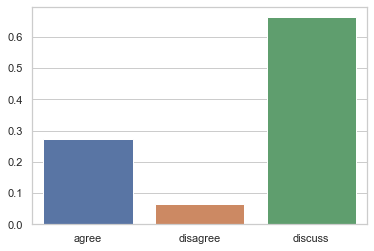

In [5]:
# get proportions of each class for TRAIN
ys = list(map(lambda x: int(x[1]), train_dataloader))
agree_prop, disagree_prop, discuss_prop = map(lambda val: proportion(ys, val), [0, 1, 2])
sns.barplot(x=['agree', 'disagree', 'discuss'], y=[agree_prop, disagree_prop, discuss_prop])

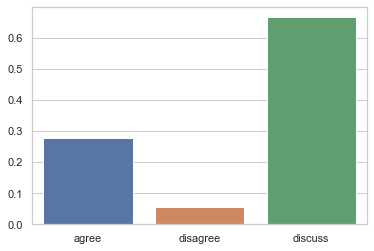

In [7]:
# get proportions of each class for VAL
ys = list(map(lambda x: int(x[1]), val_dataloader))
agree_prop, disagree_prop, discuss_prop = map(lambda val: proportion(ys, val), [0, 1, 2])
sns.barplot(x=['agree', 'disagree', 'discuss'], y=[agree_prop, disagree_prop, discuss_prop])

### Computing class weights based on relative frequency
See: https://androidkt.com/how-to-use-class-weight-in-crossentropyloss-for-an-imbalanced-dataset/

In [9]:
from sklearn.utils import class_weight

class_weight.compute_class_weight('balanced', [0, 1, 2], ys)

array([1.20017873, 5.86462882, 0.50093249])